# Algorithmic state abstraction

In the previous notebook, we saw that not all variables in the state space contribute equally to the value function. Some combinations of variables preserve the value function almost perfectly, while others lead to large deviations. Heuristic state abstraction methods try to discover which variables can be safely combined by empirically reducing the MDP along each dimension and measuring the loss in value accuracy. However, from the concept of state equivalence, we know that if two states share exactly the same transition probabilities and immediate rewards, merging them preserves the optimal value function with no loss. The bisimulation method formalizes this equivalence, but its limitation is that it only allows merging exactly equivalent states—preventing further compression of the MDP.

This naturally raises the question of whether there exists a middle ground between strict bisimulation and purely heuristic abstraction: can we merge approximately equivalent states—those with similar but not identical transition and reward structures—without heavily distorting the value function? Intuitively, if exact equivalence guarantees perfect preservation, near-equivalence should yield good approximations. Indeed, several approaches exploit this idea, performing abstraction in a guided way using the transition and reward structure of the MDP <a name="bib_ref-1"></a>[<sup>[1]</sup>](#bib_ref-1) <a name="bib_ref-2"></a>[<sup>[2]</sup>](#bib_ref-2) <a name="bib_ref-3"></a>[<sup>[3]</sup>](#bib_ref-3). Bisimulation can thus be seen as the most stringent case of a broader family of algorithmic state abstraction methods.

## Metric for state abstraction
Most of the algorithmic literature focuses on designing specific procedures to achieve a particular level of abstraction efficiently—e.g., algorithms that simplify the MDP while preserving the probability of reaching certain states within a given horizon. In contrast, our goal is not to specify which algorithm the brain might implement, but to test whether and how much abstraction occurs at all. If the brain reduces the complexity of its decision problem, it likely trades off computational cost against accuracy in expected return. Following the logic of bisimulation, the optimal way to do this is to aggregate states with similar transition and reward functions—states that “behave” similarly enough to not disrupt the resulting value function.

This is why we use the bisimulation metric proposed by Ferns and colleagues <a name="bib_ref-4"></a>[<sup>[4]</sup>](#bib_ref-4) <a name="bib_ref-5"></a>[<sup>[5]</sup>](#bib_ref-5). Rather than yielding one specific abstraction, this metric defines a continuous distance between states based on their transition and reward similarity. By setting a distance threshold $\epsilon$, we can aggregate all states within $\epsilon$ distance of each other. Small $\epsilon$ values correspond to fine-grained, nearly exact models (little abstraction), while large $\epsilon$ values yield coarser, more compact models (strong abstraction). Thus, instead of committing to one algorithmic level of simplification, the bisimulation metric provides a principled way to parameterize the entire continuum of possible abstractions, from the full MDP to a single aggregated state.

We can simply compute the (approximated) bisimulation distance <a name="bib_ref-4"></a>[<sup>[4]</sup>](#bib_ref-4) for each pairs of states in our state space:

In [ ]:
import numpy as np

from utils import bisim_metric, plot_state_matrix
from MarkovDecisionProcess import MDP
from TaskConfig import LimitedEnergyTask
import matplotlib.pyplot as plt

# Create the task and its parameters (transition probability, reward...):
task = LimitedEnergyTask()
task.build()

# Create full MDP and compute solution for later reference:
task_mdp = MDP(task.states, task.tp, task.r, s2i=task.s2i)
V_full, Q_full = task_mdp.backward_induction()
R_full = task_mdp.expected_return(task_mdp.greedy_policy(Q_full), initial_energy=3)

# Compute pairwise distances:
distances_matrix = bisim_metric(task.tp, task.r, gamma=0.9, tol=1e-6, njobs=-1, max_iters=1000)
distances_matrix = distances_matrix / np.max(distances_matrix)

  1%|▏         | 13/1000 [1:07:47<89:17:12, 325.67s/it]

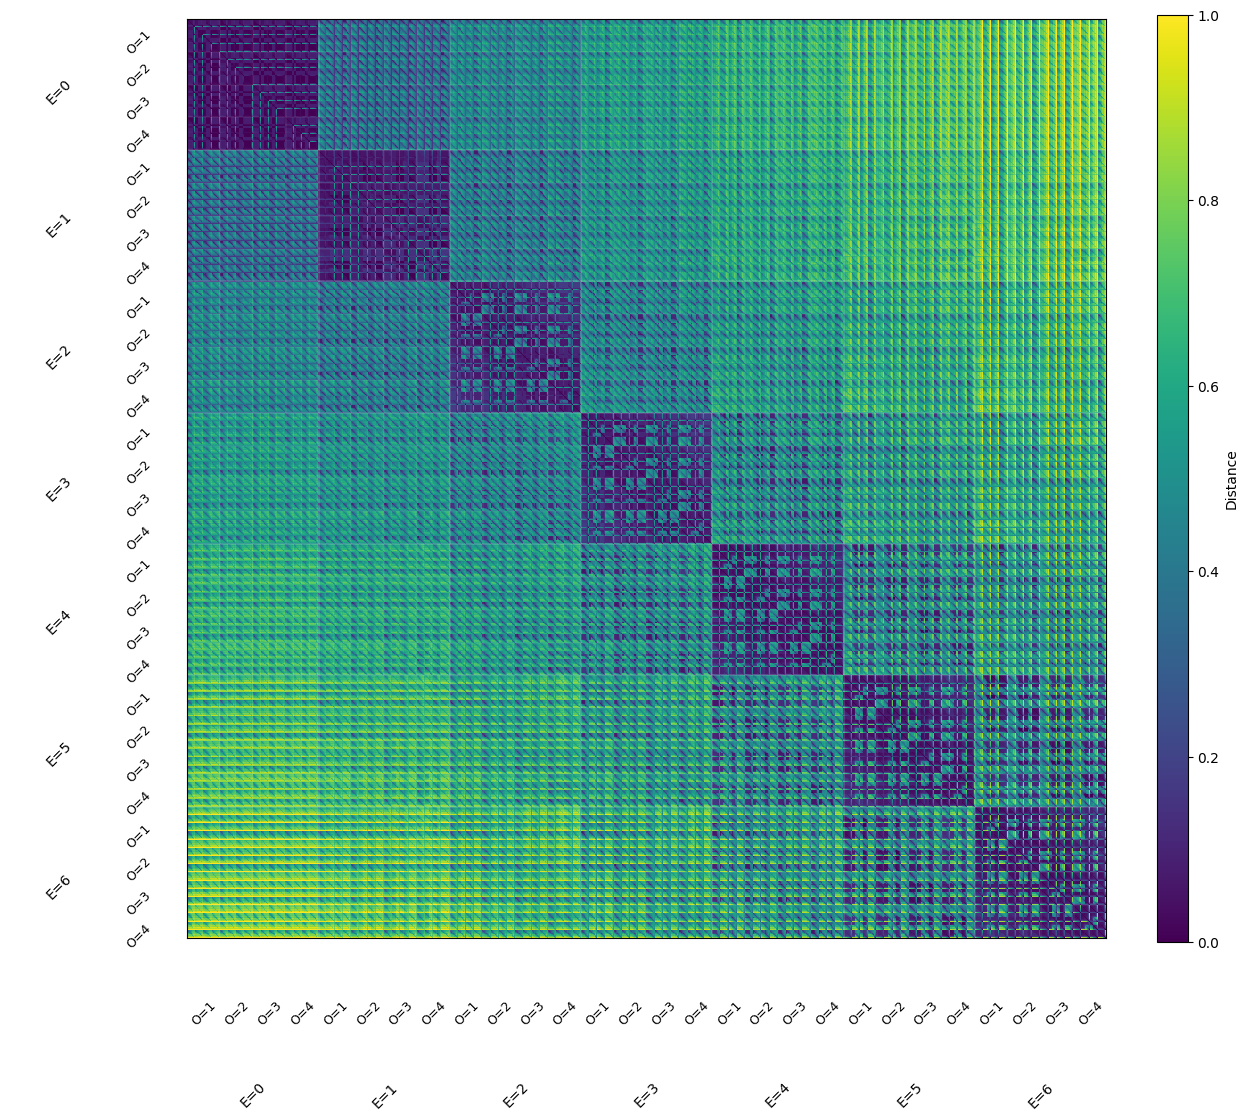

In [ ]:
# Plot the distance matrix:
plot_state_matrix(distances_matrix, task.states, feature_names=["E", "O", "CC", "FC", "T"], depth=2)
plt.show()

Now that we have computed the pairwise distances between all state pairs, we can try to find "clusters" of states, i.e. classes, which are separated by a maximum distance that we can define. Importantly, unlike in the exact bisimulation were we could simply look for all groups of states that were equivalent, creating clusters is a bit more involved in that case. Let's say we have three states $s_1$, $s_2$, and $s_3$, and the following distances between them: $d(s_1, s_2) = 0.1$, $d(s_2, s_3) = 0.1$. We would be tempted to put all three states in the same cluster, but we could be lumping states that are distant from each other if $d(s_1, s_3) > 0.1$. 

When creating classes based on a distance $\epsilon$, we want to make sure that the distance that separates all the states within a class is $\le\epsilon$. To do so, we will use hierarchical clustering with complete linkage. This is a clustering technique that generates clusters iteratively by combining clusters based on the maximal distance between pairs of units within clusters <a name="bib_ref-6"></a>[<sup>[6]</sup>](#bib_ref-6)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from utils import state_classes_from_lbl, avg_reduce_mdp, reduced2full_value
from tqdm import tqdm
R_full = task_mdp.expected_return(task_mdp.greedy_policy(Q_full), initial_energy=3)
unique_dist = np.unique(distances_matrix)
# Lists to store results:
abstraction_distance = []
abstraction_size = []
abstraction_return = []
abstraction_return_accuracy = []
value_mse = []
variables_names = ["energy", "offers", "current cost", "future cost", "t"]
vor = []

# Loop through every 10 distances:
for eps in tqdm(unique_dist): #unique_dist:
    # Find states clusters
    states_lbl = AgglomerativeClustering(distance_threshold=eps, 
                                         n_clusters=None, linkage='complete', metric='precomputed').fit(distances_matrix).labels_
    # Create state classes:
    state_classes = state_classes_from_lbl(task.states, states_lbl)
    # Reduce the MDP accordingly:
    statesR, tpR, rR, class_of_state = avg_reduce_mdp(state_classes, task_mdp.tp, task_mdp.r, task_mdp.s2i)
    # Create reduced MDP:
    task_mdp_reduced = MDP(statesR, tpR, rR)
    # Solve the MDP:
    V_R, Q_R = task_mdp_reduced.backward_induction()
    # Project back to full space:
    V_from_reduced, Q_from_reduced = reduced2full_value(class_of_state, V_R, Q_R)
    # Compute the expected return:
    abstraction_return.append(task_mdp.expected_return(task_mdp.greedy_policy(Q_from_reduced), initial_energy=3))
    abstraction_return_accuracy.append(1 - (R_full - abstraction_return[-1])/R_full)
    abstraction_distance.append(eps)
    abstraction_size.append(len(state_classes))
    vor.append(abstraction_return[-1] - len(state_classes))
    value_mse.append(((V_full - V_from_reduced)**2).mean())

# Convert to numpy arrays:
abstraction_size = np.array(abstraction_size)
abstraction_return = np.array(abstraction_return)
abstraction_distance = np.array(abstraction_distance)
abstraction_return_accuracy = np.array(abstraction_return_accuracy)
value_mse = np.array(value_mse)

  0%|          | 0/13599 [00:00<?, ?it/s]

100%|██████████| 13599/13599 [08:12<00:00, 27.59it/s]


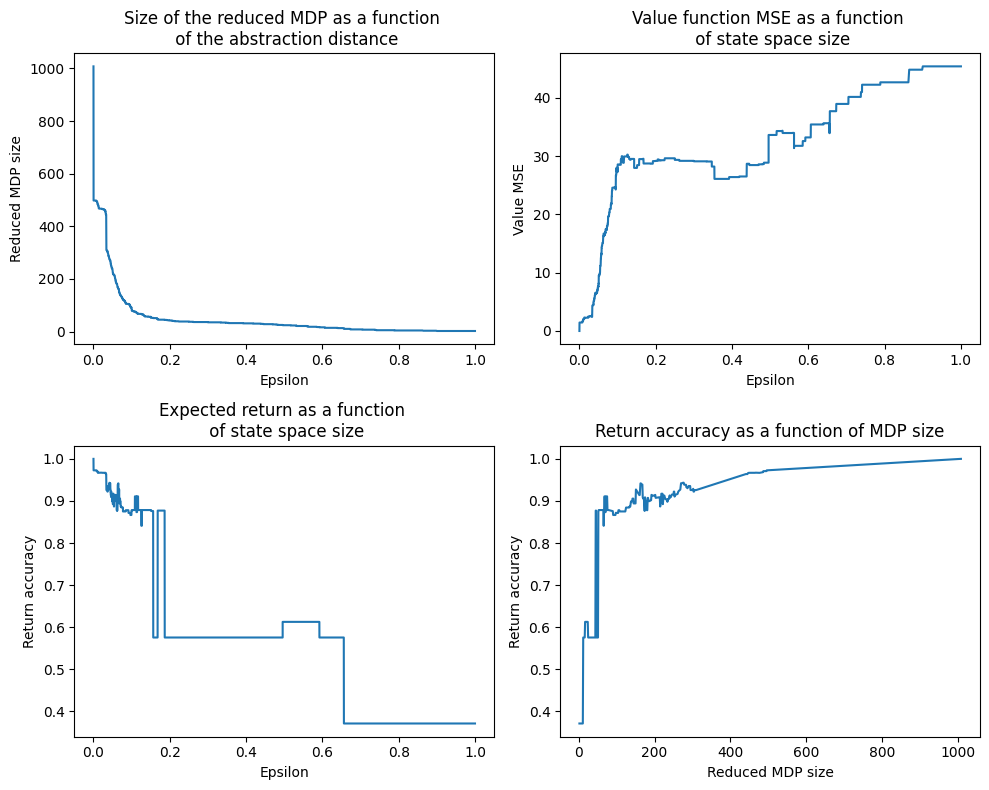

In [ ]:
# Plot the surface
fig, ax= plt.subplots(2, 2, figsize=[10, 8])
# Plot the expected return as a function of the size of the abstraction distance
ax[0, 0].plot(abstraction_distance, abstraction_size)
ax[0, 0].set_ylabel('Reduced MDP size')
ax[0, 0].set_xlabel('Epsilon')
ax[0, 0].set_title('Size of the reduced MDP as a function \n of the abstraction distance')

# Plot the expected return as a function of the size of the abstracted MDP
ax[1, 0].plot(abstraction_distance, abstraction_return_accuracy) # , c = abstraction_distance)
ax[1, 0].set_ylabel('Return accuracy')
ax[1, 0].set_xlabel('Epsilon')
ax[1, 0].set_title('Expected return as a function \n of state space size')

# Plot the expected return as a function of the size of the abstraction distance
ax[0, 1].plot(abstraction_distance, value_mse)  #, c = abstraction_distance)
ax[0, 1].set_ylabel('Value MSE')
ax[0, 1].set_xlabel('Epsilon')
ax[0, 1].set_title('Value function MSE as a function \n of state space size')
# plt.colorbar(sc, label='Abstraction distance')

# Plot the value of representation function of the size of the abstraction distance
ax[1, 1].plot(abstraction_size, abstraction_return_accuracy)
ax[1, 1].set_ylabel('Return accuracy')
ax[1, 1].set_xlabel('Reduced MDP size')
ax[1, 1].set_title('Return accuracy as a function of MDP size')

plt.tight_layout()
plt.show()

The top-left figure shows how the size of the reduced MDP changes with the aggregation distance, $\epsilon$. As $\epsilon$ increases, more states are merged together, so the MDP becomes smaller—eventually collapsing into a single state when $\epsilon$ is large. The reduction happens exponentially, meaning that a small increase in $\epsilon$ can dramatically shrink the MDP.

The bottom-left figure shows how accurate the expected return from the reduced MDP is compared to the optimal return obtained from the full MDP. A value of 1 means the reduced model performs as well as the optimal one, while 0 would mean no return at all (though in practice, even random policies yield some return). The key observation is that performance stays near optimal until $\epsilon$ reaches a fairly high value, meaning we can significantly compress the state space without sacrificing much reward. In fact, we can cut the MDP’s size by more than half and still perform almost optimally. This is important, because it suggests that reducing the MDP before solving it can dramatically simplify computation—a process that might reflect how the brain itself manages complex decision problems.

The top-right figure shows the mean squared error of the value function compared to the optimal one, as a function of $\epsilon$. Again, the value estimates remain close to optimal even for large $\epsilon$, confirming that strong abstraction barely affects performance.

The graph on the bottom right corner shows the value of representation derived from Ho et al. (2022) <a name="bib_ref-7"></a>[<sup>[7]</sup>](#bib_ref-7), which measures how efficient a reduced MDP is by comparing its return to its size. A high VOR means the abstraction is both compact and effective. If the brain indeed performs this kind of abstraction, it might aim to find the $\epsilon$ that maximizes VOR—achieving the most useful compression without losing decision quality. This idea allows us to make concrete predictions about how abstraction levels might be chosen in neural computation.

## Predictions associated with bisimulation metric

The bisimulation metric provides a principled way to understand how the brain might simplify complex problems. It defines how states can be merged while preserving as much of the original MDP’s reward structure as possible. Because the metric is quantitative, it allows us to adjust the level of abstraction continuously—from fine-grained to very coarse—while maintaining control over the trade-off between precision and simplicity.

From this, several predictions follow. The first relates to VOR: if the brain seeks to balance accuracy and efficiency, it should choose abstractions corresponding to the $\epsilon$ that maximizes VOR. However, if cognitive resources are limited—say, the brain can only handle MDPs with a fixed number of states—then abstraction would not depend on VOR, but on reaching that computational limit. In that case, the brain would select $\epsilon$ so that the reduced MDP fits within its processing capacity.

Alternatively, if computational capacity itself varies with factors like motivation or task difficulty, then the chosen $\epsilon$ would change accordingly. More motivated individuals, or those facing higher task rewards, would engage finer-grained representations (smaller $\epsilon$), since they can justify expending more cognitive resources for better precision.

## Decision values of state abstraction

We can plot the decision values at various $\epsilon$ to see what things look like:

<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_23644\4272309915.py:18: SyntaxWarning: invalid escape sequence '\e'
  task_mdp.plot_dv(Q_from_reduced[:, 1]-Q_from_reduced[:, 0], title=f'Decision value at $\epsilon={eps}$')


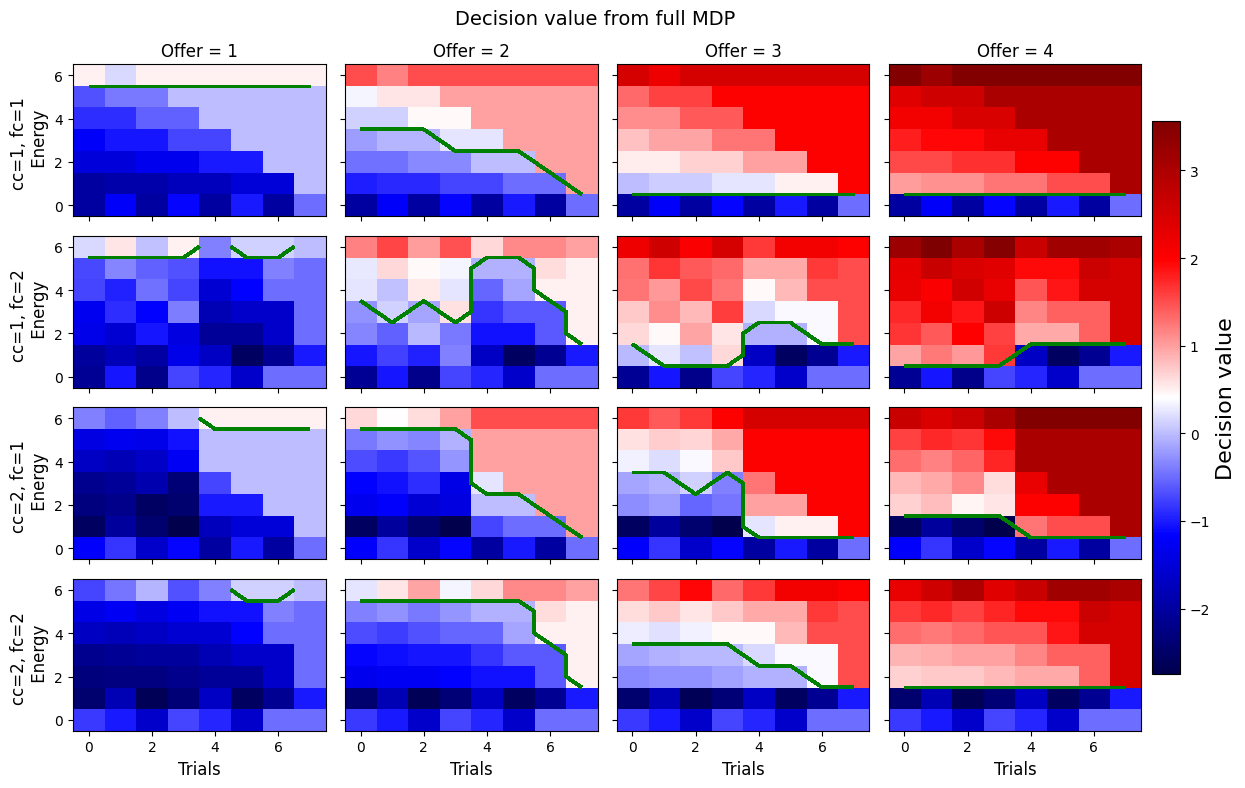

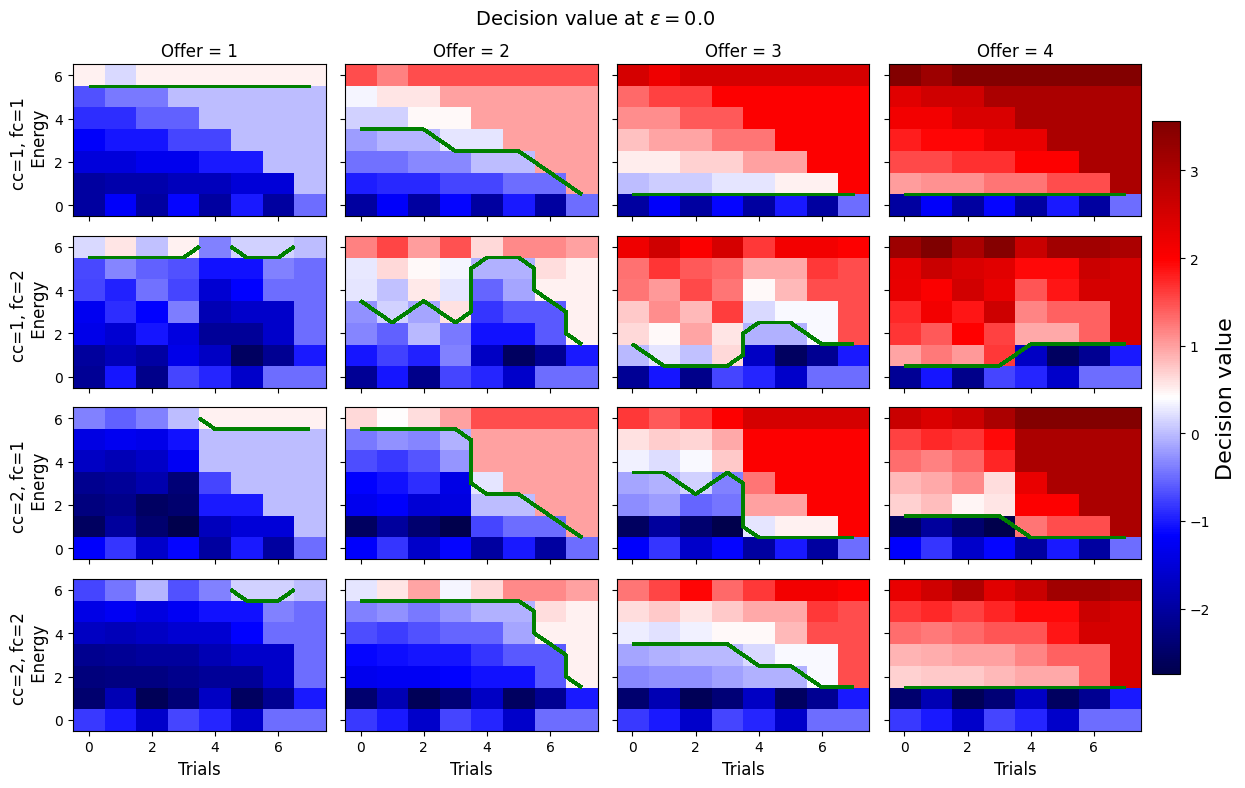

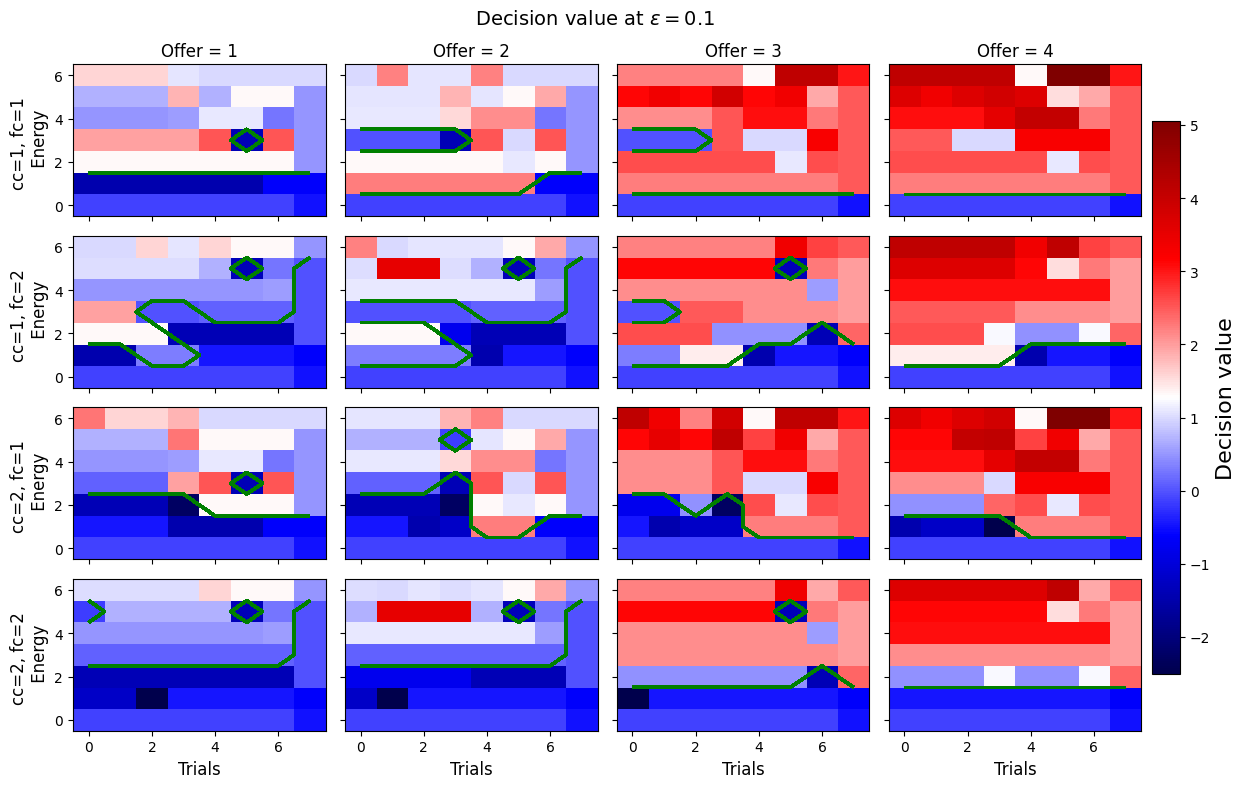

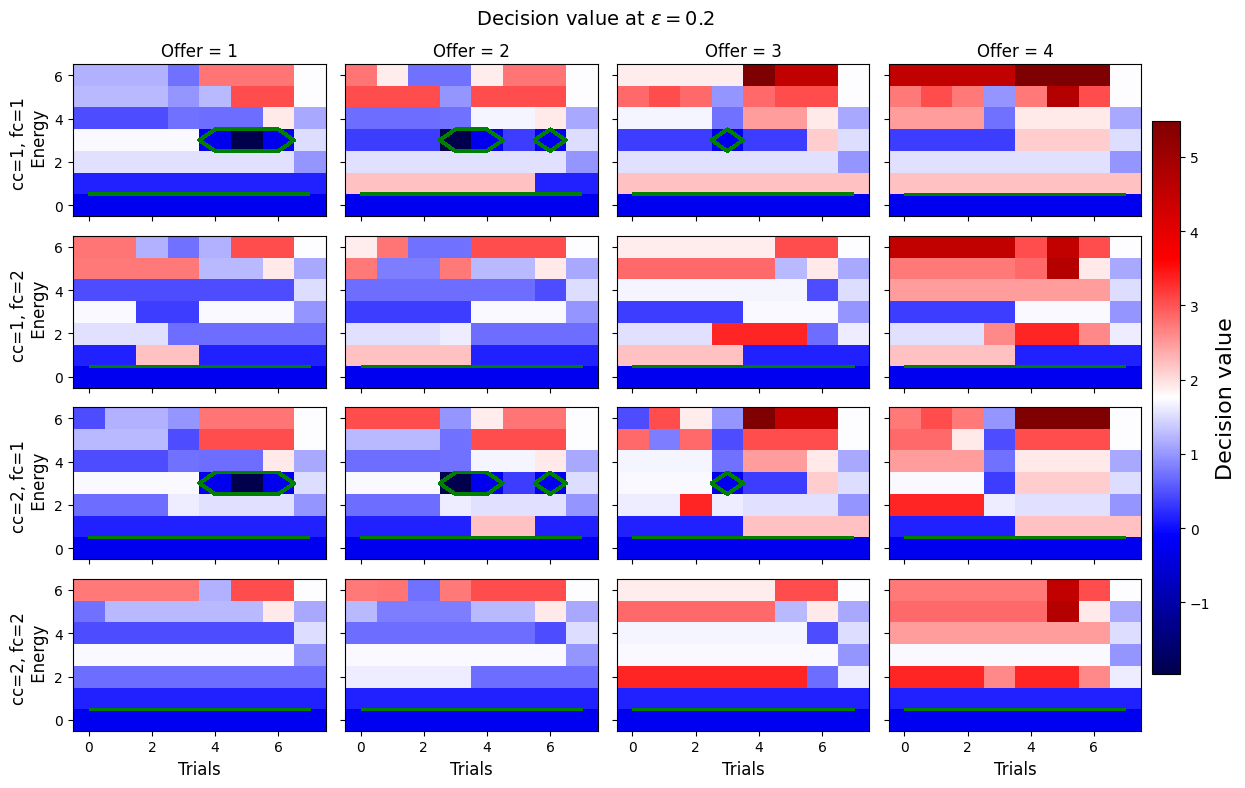

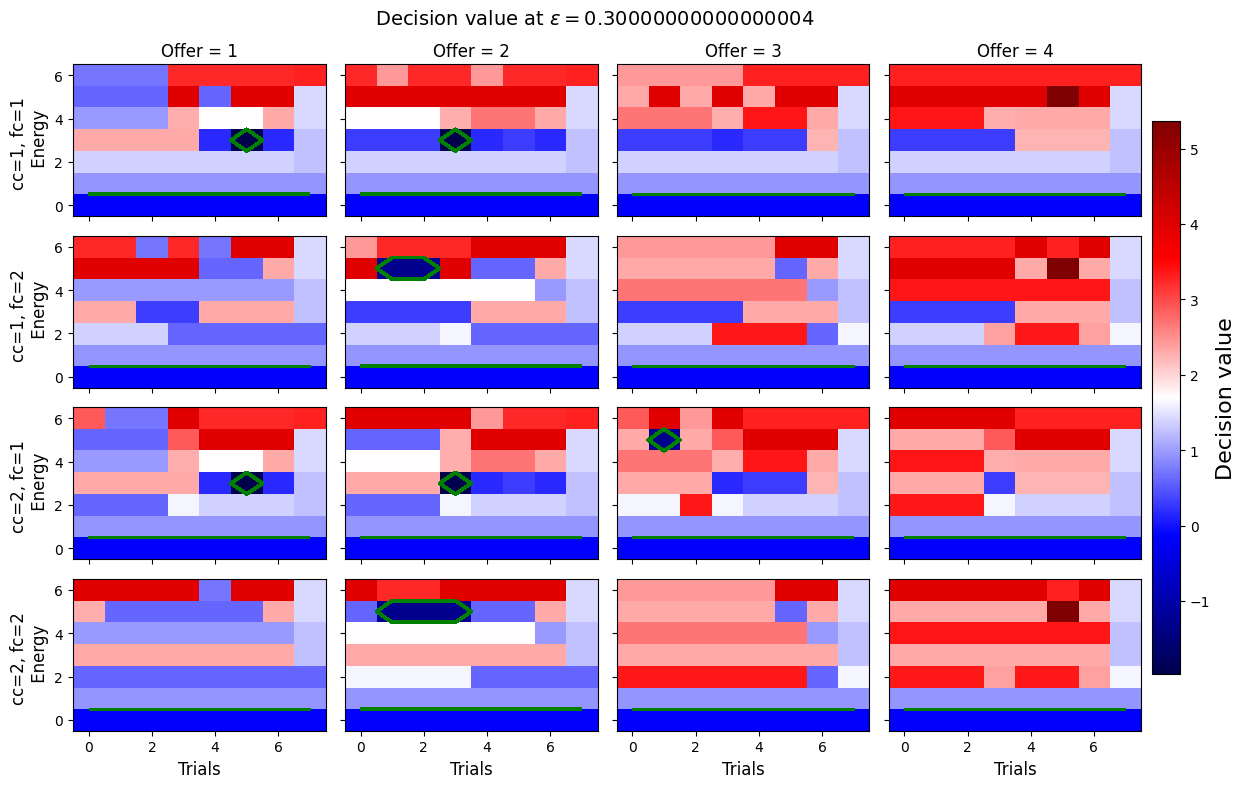

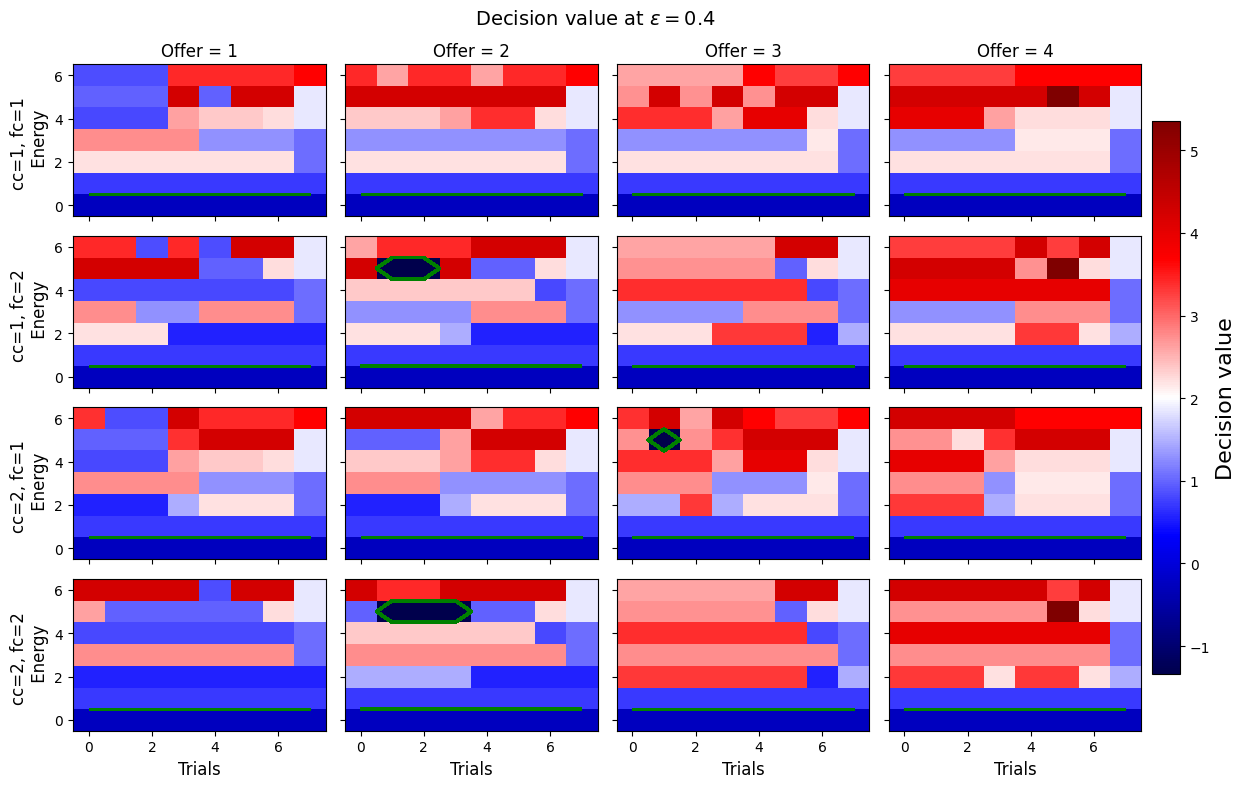

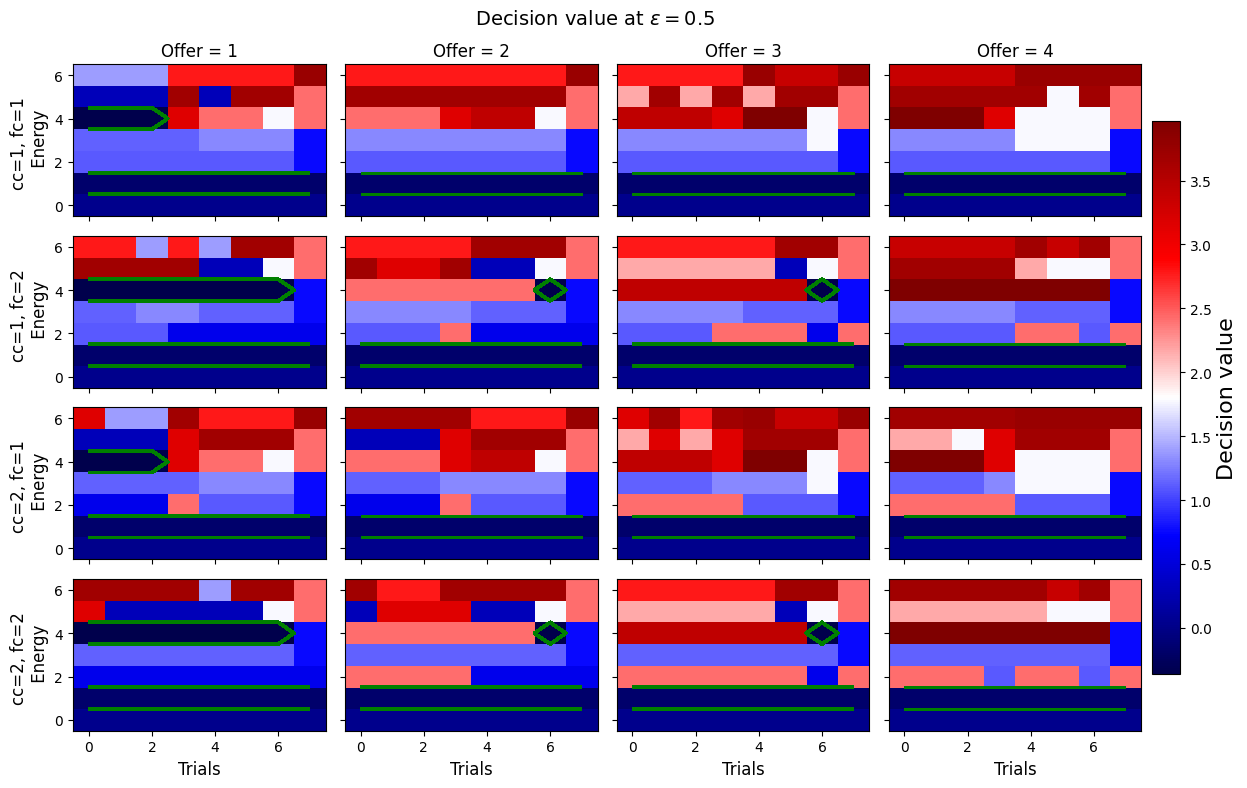

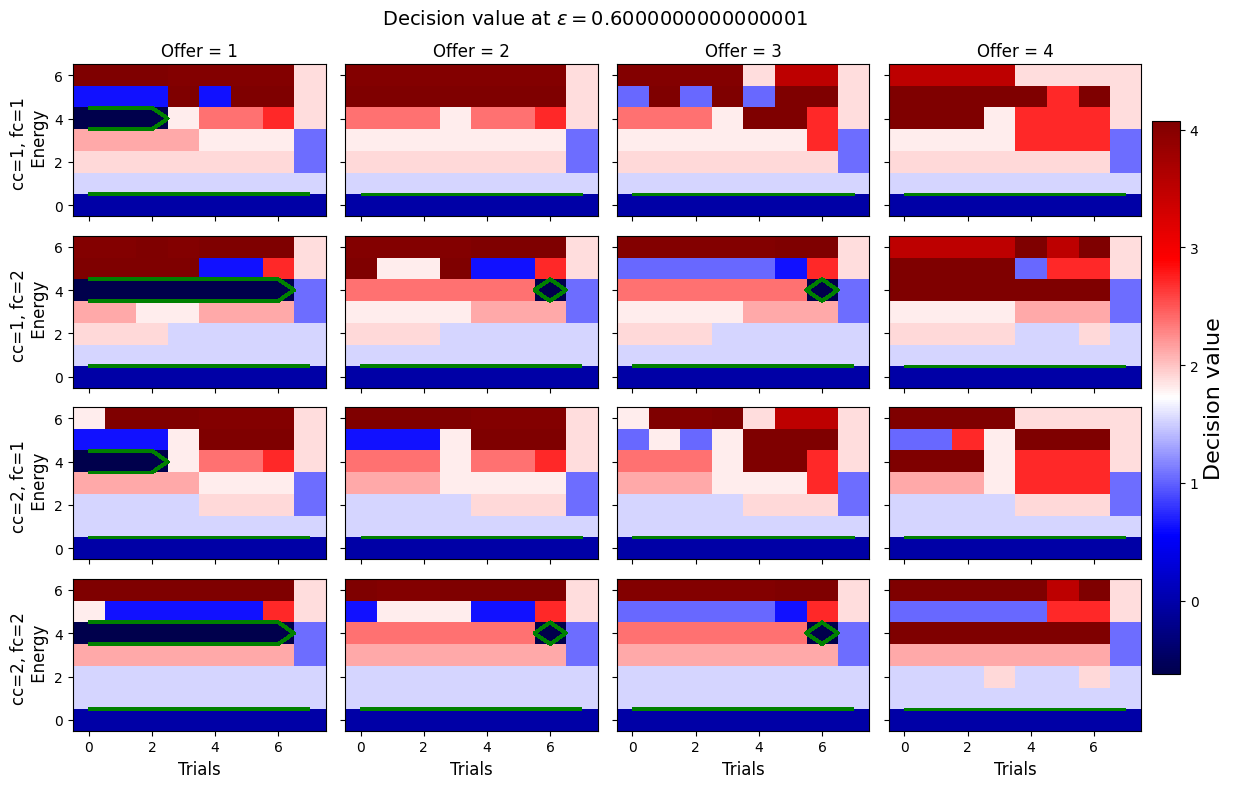

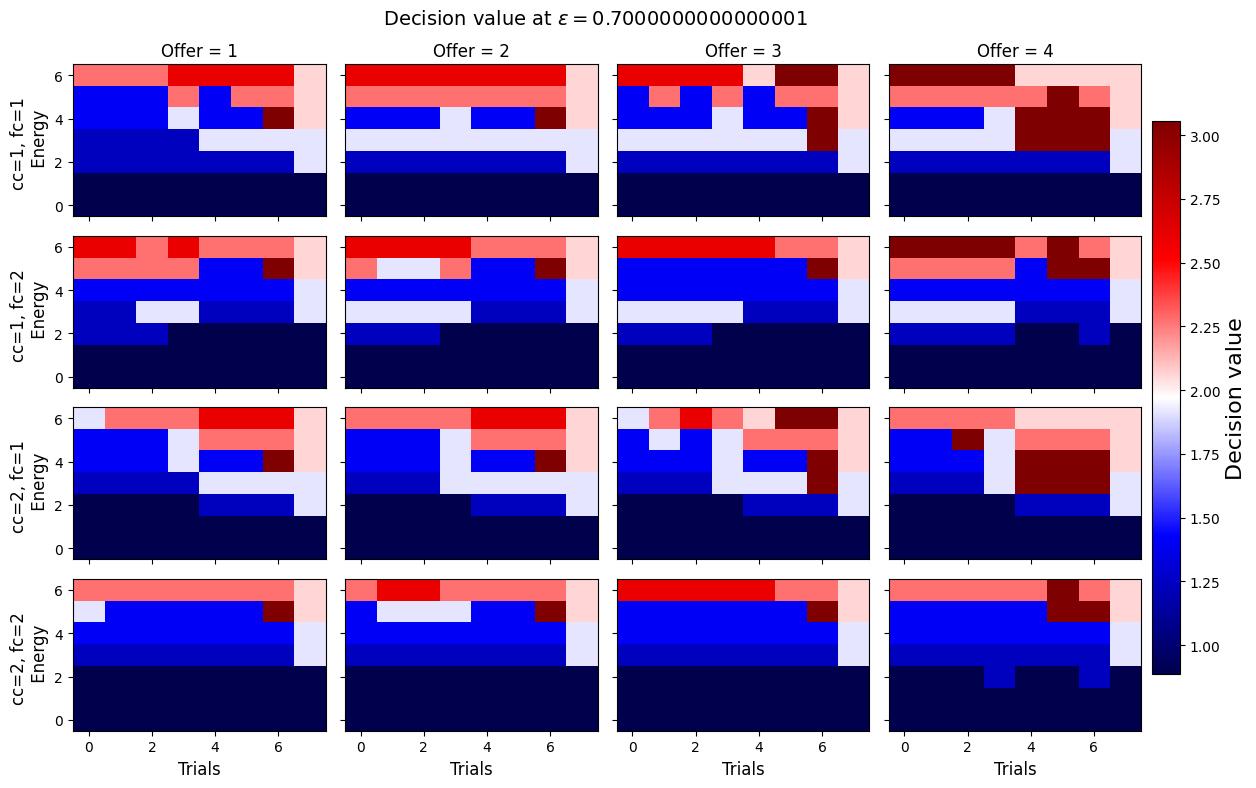

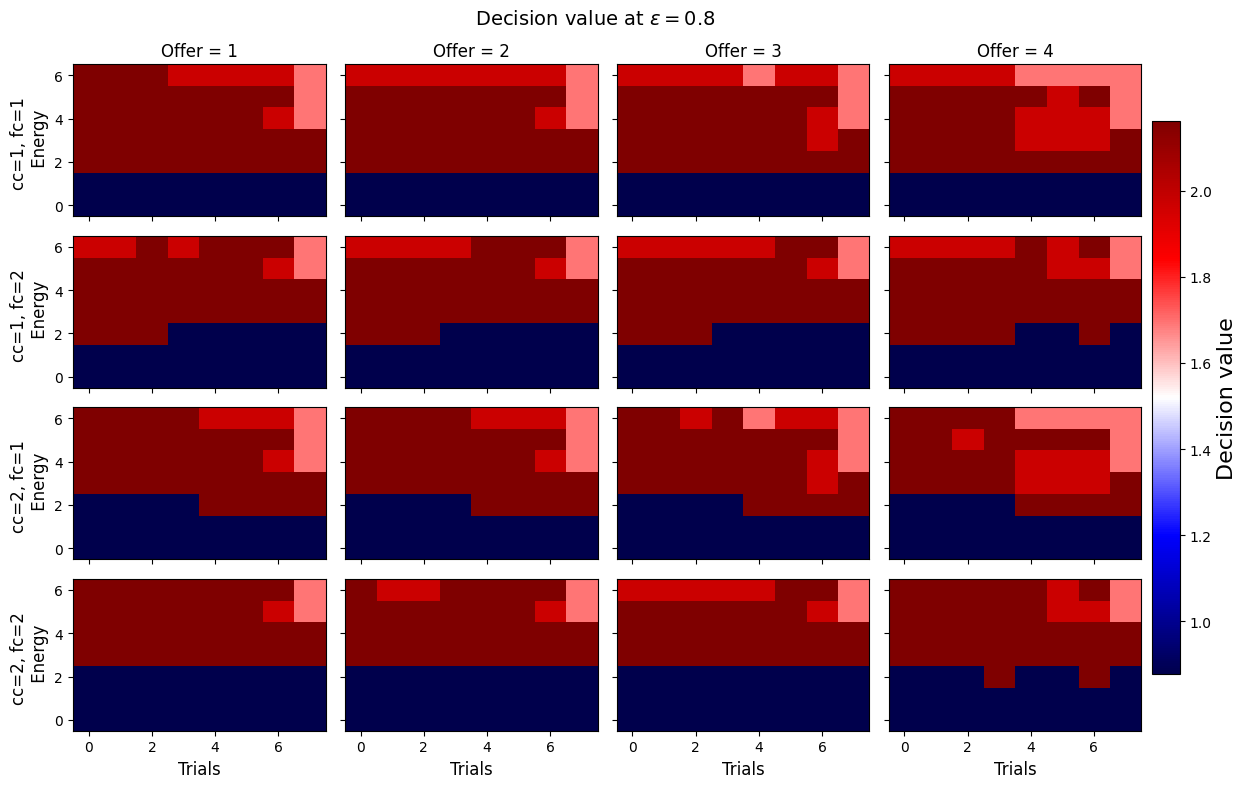

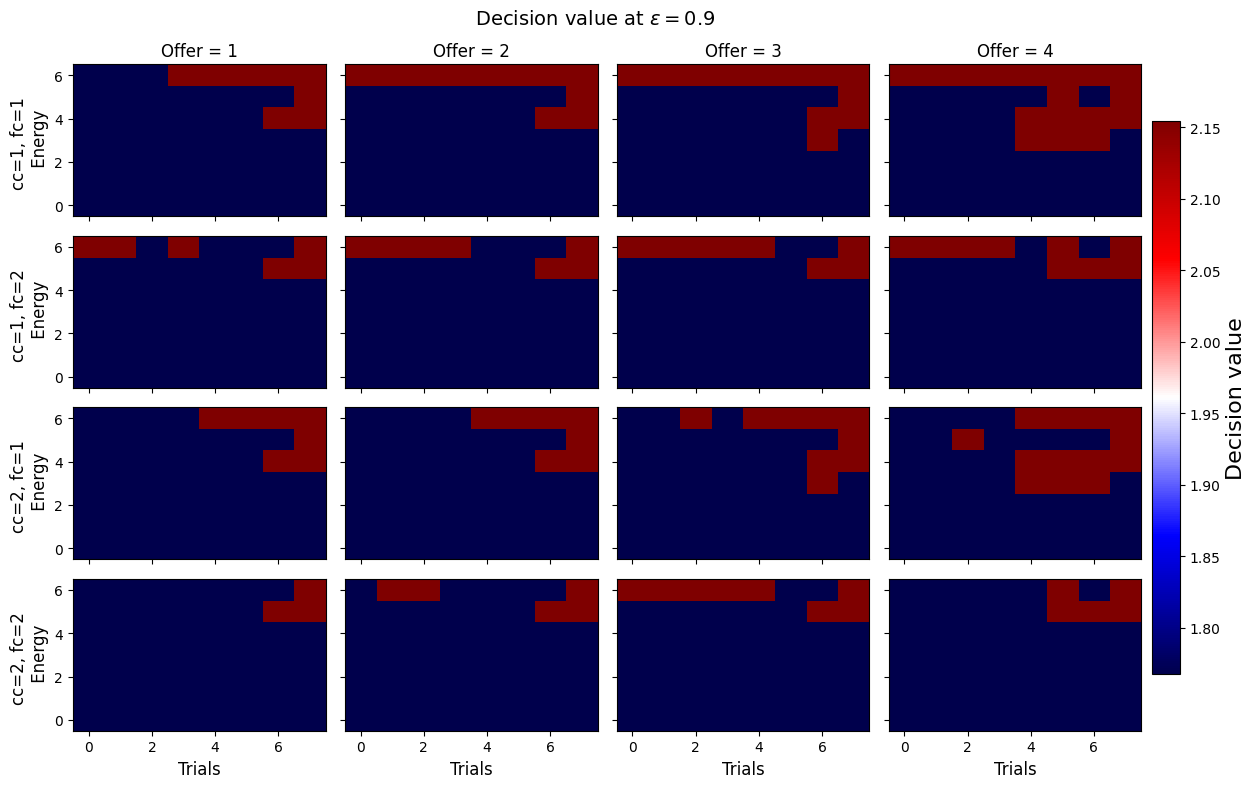

In [ ]:
# Plot the decision values:
task_mdp.plot_dv(Q_full[:, 1]-Q_full[:, 0], title='Decision value from full MDP')

for eps in np.arange(0, 1, 0.1):
    # Find states clusters
    states_lbl = AgglomerativeClustering(distance_threshold=eps, 
                                         n_clusters=None, linkage='complete', metric='precomputed').fit(distances_matrix).labels_
    # Create state classes:
    state_classes = state_classes_from_lbl(task.states, states_lbl)
    # Reduce the MDP accordingly:
    statesR, tpR, rR, class_of_state = avg_reduce_mdp(state_classes, task_mdp.tp, task_mdp.r, task_mdp.s2i)
    # Create reduced MDP:
    task_mdp_reduced = MDP(statesR, tpR, rR)
    # Solve the MDP:
    V_R, Q_R = task_mdp_reduced.backward_induction()
    # Project back to full space:
    V_from_reduced, Q_from_reduced = reduced2full_value(class_of_state, V_R, Q_R)
    task_mdp.plot_dv(Q_from_reduced[:, 1]-Q_from_reduced[:, 0], title=f'Decision value at $\epsilon={eps}$')
    
plt.show()

# Bibliography
<a name="bib_ref-1"></a>[<sup>[1]</sup>](#bib_ref-1) Li, Lihong, Thomas J. Walsh, and Michael L. Littman. "Towards a unified theory of state abstraction for MDPs." AI&M 1.2 (2006): 3.

<a name="bib_ref-2"></a>[<sup>[2]</sup>](#bib_ref-2) Dean, T., & Givan, R. (1997, July). Model minimization in Markov decision processes. In AAAI/IAAI (pp. 106-111).

<a name="bib_ref-3"></a>[<sup>[3]</sup>](#bib_ref-3) Givan, R., Dean, T., & Greig, M. (2003). Equivalence notions and model minimization in Markov decision processes. Artificial intelligence, 147(1-2), 163-223.

<a name="bib_ref-4"></a>[<sup>[4]</sup>](#bib_ref-4) Ferns, N., Castro, P. S., Precup, D., & Panangaden, P. (2012). Methods for computing state similarity in Markov decision processes. arXiv preprint arXiv:1206.6836.

<a name="bib_ref-5"></a>[<sup>[5]</sup>](#bib_ref-5) Ferns, N., Panangaden, P., & Precup, D. (2004, July). Metrics for Finite Markov Decision Processes. In UAI (Vol. 4, pp. 162-169).

<a name="bib_ref-6"></a>[<sup>[6]</sup>](#bib_ref-6) Complete linkage clustering, wikipedia, https://en.wikipedia.org/wiki/Complete-linkage_clustering

<a name="bib_ref-7"></a>[<sup>[7]</sup>](#bib_ref-7) Ho, M. K., Abel, D., Correa, C. G., Littman, M. L., Cohen, J. D., & Griffiths, T. L. (2022). People construct simplified mental representations to plan. Nature, 606(7912), 129-136.